In [21]:
import gensim.downloader as api
from sklearn.datasets import fetch_20newsgroups
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, Conv1D, MaxPooling1D, Dense, GlobalMaxPooling1D, LSTM
import numpy as np
import matplotlib.pyplot as plt

In [22]:
EMBEDDING_DIMENSIONALITY = 300

# load in dataset
dataset = fetch_20newsgroups(subset='all', remove=('headers', 'footers'))
samples = dataset.data
labels = dataset.target

In [23]:
# tokenize words from samples
tokenizer = Tokenizer()
tokenizer.fit_on_texts(samples)
num_words = len(tokenizer.word_index) + 1

# convert to sequences and pad sequences to all be same size
sequences = tokenizer.texts_to_sequences(samples)
padded_sequences = pad_sequences(sequences, maxlen=EMBEDDING_DIMENSIONALITY)

In [24]:
# partition data
x_train, x_test, y_train, y_test = train_test_split(padded_sequences, labels, test_size=0.2, shuffle=True)

In [25]:
# load in embeddings and create embedding matrix
embeddings = api.load("word2vec-google-news-300")

embedding_matrix = np.zeros((num_words, EMBEDDING_DIMENSIONALITY))
for word, index in tokenizer.word_index.items():
    if word in embeddings:
        embedding_matrix[index] = embeddings[word]

In [26]:
# create CNN model and compile
model = Sequential([
    Embedding(input_dim=num_words, output_dim=EMBEDDING_DIMENSIONALITY, weights=[embedding_matrix], input_length=EMBEDDING_DIMENSIONALITY, trainable=False),
    Conv1D(128, 5, activation="relu"),
    MaxPooling1D(3),
    Conv1D(128, 5, activation="relu"),
    GlobalMaxPooling1D(),
    Dense(20, activation='softmax')
])

model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
print(model.summary())

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 300, 300)          47453100  
                                                                 
 conv1d_6 (Conv1D)           (None, 296, 128)          192128    
                                                                 
 max_pooling1d_3 (MaxPooling  (None, 98, 128)          0         
 1D)                                                             
                                                                 
 conv1d_7 (Conv1D)           (None, 94, 128)           82048     
                                                                 
 global_max_pooling1d_3 (Glo  (None, 128)              0         
 balMaxPooling1D)                                                
                                                                 
 dense_3 (Dense)             (None, 20)               

In [27]:
# train model
model_history = model.fit(x_train, y_train, batch_size=128, epochs=20, validation_split=0.1)

Epoch 1/20
106/106 [==============================] - 13s 117ms/step - loss: 2.1811 - accuracy: 0.3329 - val_loss: 1.3916 - val_accuracy: 0.5550
Epoch 2/20
106/106 [==============================] - 12s 116ms/step - loss: 1.1323 - accuracy: 0.6431 - val_loss: 1.0869 - val_accuracy: 0.6592
Epoch 3/20
106/106 [==============================] - 12s 117ms/step - loss: 0.8619 - accuracy: 0.7350 - val_loss: 1.0147 - val_accuracy: 0.6658
Epoch 4/20
106/106 [==============================] - 12s 117ms/step - loss: 0.6892 - accuracy: 0.7963 - val_loss: 0.9282 - val_accuracy: 0.7069
Epoch 5/20
106/106 [==============================] - 12s 117ms/step - loss: 0.5589 - accuracy: 0.8400 - val_loss: 0.9052 - val_accuracy: 0.7029
Epoch 6/20
106/106 [==============================] - 12s 117ms/step - loss: 0.4464 - accuracy: 0.8794 - val_loss: 0.8807 - val_accuracy: 0.7268
Epoch 7/20
106/106 [==============================] - 12s 117ms/step - loss: 0.3386 - accuracy: 0.9207 - val_loss: 0.8871 - val_ac

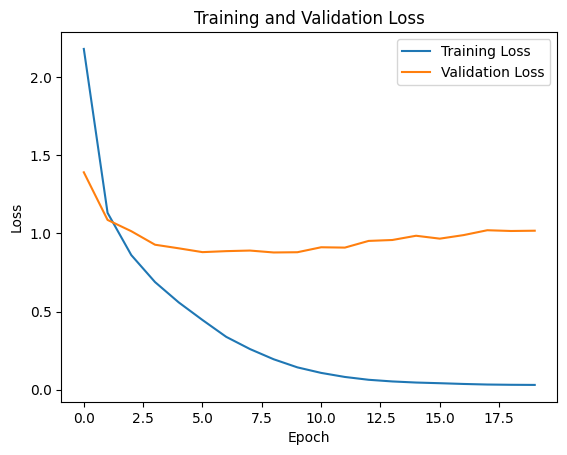

In [28]:
# plot loss curves
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [29]:
# get predictions and calculate accuracy
predictions = np.argmax(model.predict(x_test), axis=1)
accuracy = accuracy_score(y_test, predictions)
print(f"Accuracy: {accuracy}")

118/118 [==============================] - 1s 12ms/step
Accuracy: 0.7596816976127321
